### Dependencies

In [156]:
#Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import missingno as msno
#from datapackage import Package
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sts
#from iso3166 import countries
#import plotly.io as pio
#import math
#from sklearn.feature_selection import f_classif
#from scipy.stats import chi2_contingency

### Import and Cleanup

In [157]:
DF = pd.read_pickle("../Data/Popularity_DF.pkl")

In [158]:
##Basic cleanup
def cleanup(DF):
    #Language fill NaN and cleanup
    DF['Language'].fillna('Unknown', inplace=True)
    DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

    #Origin Country
    DF['Origin_Country'].fillna(value='Not_Disclosed', inplace=True)

    #Create Trended_After(Days)
    def indays(x,y):
        z=x.date()-y.date()
        return z.days
    DF['Trended_After(Days)'] = DF.apply(lambda x: indays(x['First_Trending'],x['Publish_Time']), axis=1)


    #Censorship 
    DF['censorship'] = DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
    #Create output variable
    def map_to_cat(x):
        #np.quantile(Country_Category_Popularity_DF['Total_Trend_Days'], [0.95, 0.999])
        #1 -> 'JustTrending'
        #(1 to 5] -> 'Popular' #5 is 95th %
        #(5 to 14] -> 'UlraPopular' #14 is 99.1%
        #>14 -> 'Phenomenon'
        return ('JustTrending' if x==1 else ('Popular' if x<=5 else ('UltraPopular' if x<=14 else "Phenomenon")))
    DF['Popularity_Category'] = DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
    DF['Popularity_Category'] = DF['Popularity_Category'].astype(pd.Categorical(['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon'], ordered=True))
    
    #Drop uncecessary columns
    DF.drop(['Blocked', 'Allowed'], inplace=True, axis=1)

    #Convert Duration to minutes
    DF['Duration'] = DF['Duration']/60
    #Consider only duration <=130 (to remove live sessions)
    DF = DF[DF['Duration']<=130]

    #Reset Index
    DF.reset_index(drop=True, inplace=True)
    #Check missing values
    #_=msno.matrix(DF)
    return DF

In [159]:
DF=cleanup(DF)
num_columns=['Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'Trended_After(Days)', 'PublishedAfter_in_Days']  
target=['Total_Trend_Days', 'Popularity_Category']
DF_numeric = DF[num_columns+target].copy()


# Time To trend Vs Trending Days

* Most of the trending videos were published in less than a month ago. There are only few videos those are lateblooms !
* However, given that a latebloom video is trending, the chance of this video trends >5 days increases with its age !! 

In [160]:
#Cut the number of days to start trending to 2 bins
Newness_Popularity_DF = DF.copy()
Newness_Popularity_DF['Days_to_trend']=pd.cut(Newness_Popularity_DF['Trended_After(Days)'], bins=[-1,30,np.inf],labels=['Within 1 Month', '>1 Month'])   


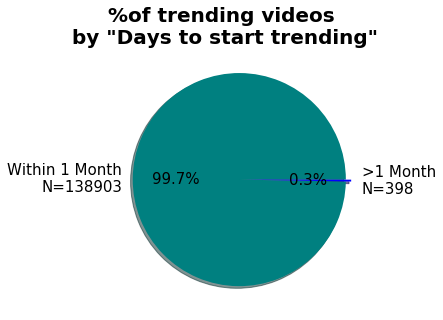

In [161]:
Newness_Count = Newness_Popularity_DF.groupby('Days_to_trend')['video_id'].count()
label=[f"{i}\nN={j}" for i,j in zip(Newness_Count.index, Newness_Count)]
ax=Newness_Popularity_DF.groupby('Days_to_trend')['video_id'].count().plot(kind='pie', colors = ["teal", "blue"], label='', labels=label, fontsize=15, shadow=True, autopct='%1.1f%%', explode=[0,0.05])  
ax.set_aspect("equal")
_=plt.suptitle('%of trending videos\n by "Days to start trending"', fontsize=20, weight='bold', y=1.1)    
_ = plt.tight_layout()
#_=plt.savefig("../Image/Perc_of_Lateblooms.png",bbox_inches = "tight")
plt.show()

In [162]:
Newness_Popularity_DF.loc[:,'Popularity_Category'] = pd.cut(Newness_Popularity_DF['Total_Trend_Days'], bins=[0,5,np.inf], labels=['Upto 5 days', '>5 Days'])

Newness_Popularity_Table=Newness_Popularity_DF.groupby(['Days_to_trend', 'Popularity_Category'])['video_id'].count().unstack()    
Newness_Popularity_Table
Newness_Popularity_Table.sum(axis=1)
Newness_Popularity_Table.apply(lambda x: 100*x/x.sum(),axis=1)

Popularity_Category,Upto 5 days,>5 Days
Days_to_trend,,
Within 1 Month,133538,5365
>1 Month,330,68


Days_to_trend
Within 1 Month    138903
>1 Month             398
dtype: int64

Popularity_Category,Upto 5 days,>5 Days
Days_to_trend,,
Within 1 Month,96.137592,3.862408
>1 Month,82.914573,17.085427


In [163]:
Labels=['<30', '(30-100]', '(100-500]', '(500-1000]', '(1000-2000]', '(2000-4000]']
Newness_Popularity_DF.loc[:,'Days_to_trend']=pd.cut(Newness_Popularity_DF['Trended_After(Days)'], bins=[-1,30,100, 500, 1000, 2000, 4000],labels=Labels) #Max is  3982 days 
Newness_Popularity_Table = pd.DataFrame(Newness_Popularity_DF.groupby('Days_to_trend')['Popularity_Category'].value_counts(normalize=True).unstack(level=1).fillna(0)['>5 Days'])


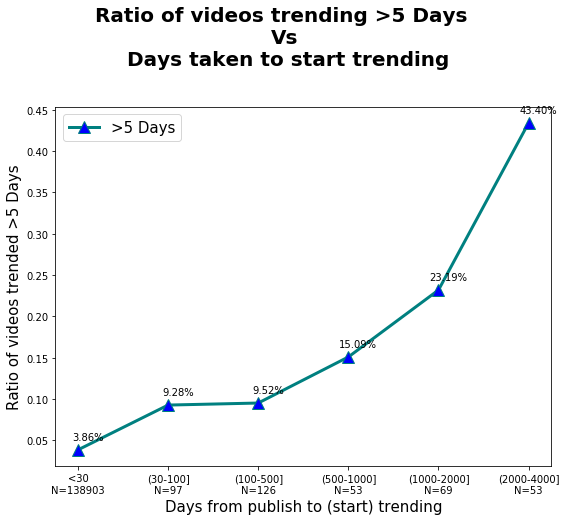

In [164]:
ax = Newness_Popularity_Table.plot(xticks=np.arange(len(Newness_Popularity_Table.index)), color = ["teal", "blue"], figsize=(8,6), linewidth=3, marker='^', markersize=12, mfc='blue')  
x_tick_labels = [f"{i}\nN={j}" for i,j in zip(Newness_Popularity_Table.index, Newness_Popularity_DF.groupby('Days_to_trend')['Popularity_Category'].value_counts().unstack(level=1).fillna(0).sum(axis=1))] 

#Annotation
x=np.arange(len(Newness_Popularity_Table.index))
_=ax.set_xticklabels(x_tick_labels)
for col in Newness_Popularity_Table.columns:
    label = ["{:.2f}%".format(text*100) for text in Newness_Popularity_Table[col].to_list()]
    y=Newness_Popularity_Table[col].to_list()
    for index in range(len(label)):
        _=ax.annotate(label[index], # this is the text
                     (x[index],y[index]), # this is the point to label
                     textcoords="offset points", # how to position the text ('offset pixels'  is the other option)
                     xytext=(10,10), # distance from text to points (x,y)
                     ha='center', # horizontal alignment can be left, right or center
                     fontsize=10,
                     color='k') 

#Beautification !!!
_=plt.suptitle('Ratio of videos trending >5 Days \nVs\n Days taken to start trending', fontsize=20, weight='bold', y=1.2)
_=ax.legend(loc='best',fontsize = 15)
_=ax.set_ylabel('Ratio of videos trended >5 Days',fontsize = 15)
_=ax.set_xlabel('Days from publish to (start) trending',fontsize = 15)
_=plt.tight_layout()

#_=plt.savefig("../Image/Latebloom_effect.png",bbox_inches = "tight")
plt.show()

# Total Views, Likes, Dislikes, Comment Count per country, and category

In [165]:
DF_FS = pd.read_pickle("../Data/Popularity_FS_DF.pkl")

In [166]:
DF_FS.reset_index(inplace=True)

In [167]:
DF_FS = cleanup(DF_FS)

In [168]:
def plot_barh(DF, Title=None, Type=None, across=None, figsize=(10,10), adjust=1.03):

    fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, tight_layout=True, figsize=figsize)
    axs = axs.ravel()
    color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
    colors = [color(0.6) for color in color_range]
    for index,col in enumerate(DF.columns):
        _=DF[col].plot(color=colors[index%10], kind='barh', alpha=1, label=col, ax=axs[index], xlim=(0, DF[col].max()*1.2), grid=False)
        
        #legend, ylabel, title
        _=axs[index].legend("")
        _=axs[index].set_ylabel(DF.index.name.replace('_', ' '),fontsize = 15)
        _=axs[index].set_title(col.replace('_', ' '),fontsize = 15)
        
        #Annotate
        for p in axs[index].patches:
            _=axs[index].annotate("{:.0f}".format(p.get_width()), (p.get_width()+0.1, p.get_y()*adjust), fontsize=10)
    _=plt.suptitle(f"{Type} {Title} {across}", fontsize=20, weight='bold', y=1.01)
    
    #save
    _=plt.tight_layout()
    _=plt.savefig(f"../Image/{Type} Views_Likes_Comments_Across_{across}.png",bbox_inches = "tight")
    plt.show()
    
    

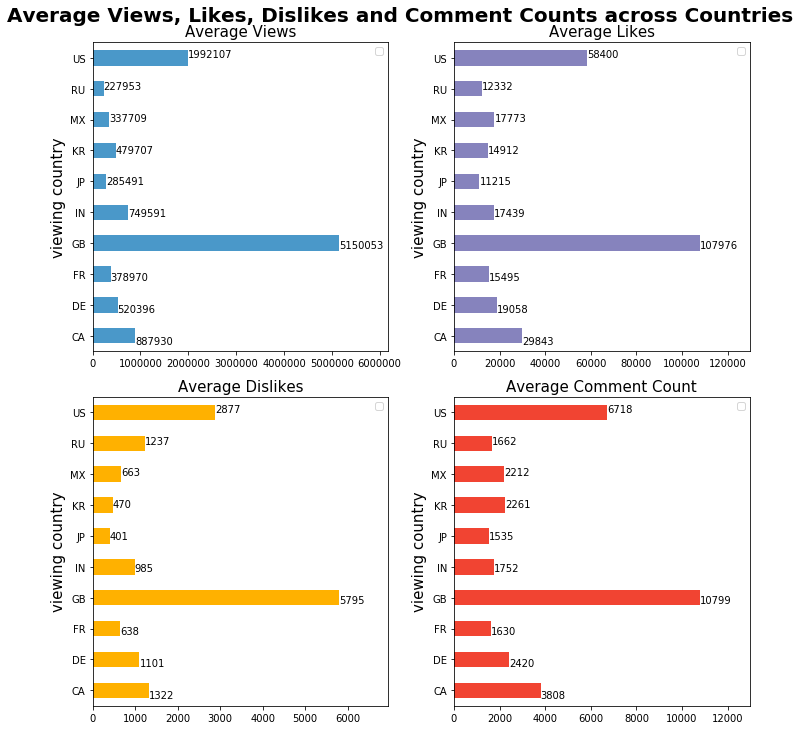

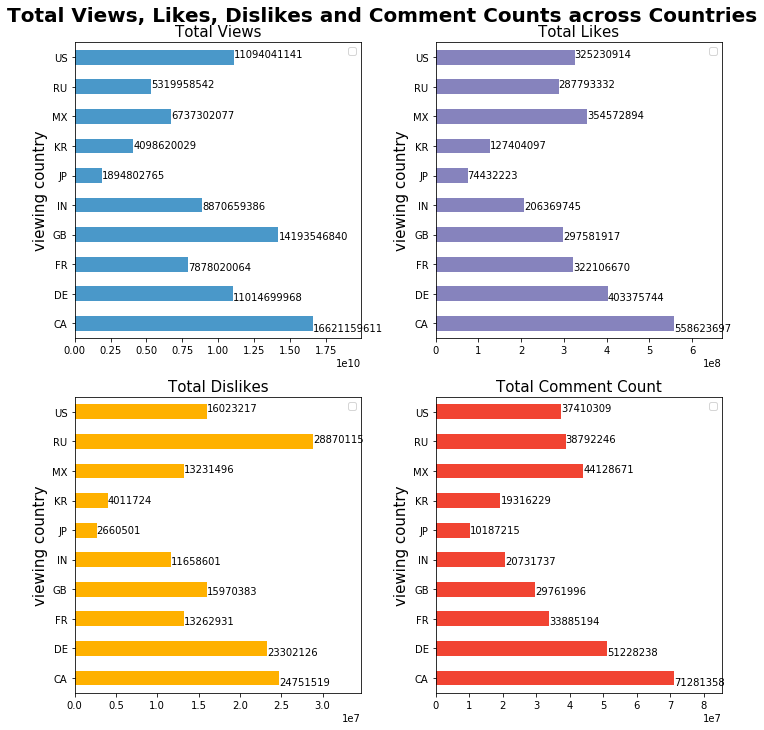

In [169]:
DF_FS_Country = DF_FS.groupby('viewing_country').aggregate(Average_Views = ('Views_F', 'mean'), Average_Likes = ('Likes_F', 'mean'), Average_Dislikes = ('Dislikes_F', 'mean'), Average_Comment_Count = ('Comment_Count_F', 'mean'))
plot_barh(DF_FS_Country, Title="Views, Likes, Dislikes and Comment Counts across", Type='Average', across="Countries")

DF_FS_Country = DF_FS.groupby('viewing_country').aggregate(Total_Views = ('Views_F', 'sum'), Total_Likes = ('Likes_F', 'sum'), Total_Dislikes = ('Dislikes_F', 'sum'), Total_Comment_Count = ('Comment_Count_F', 'sum'))
plot_barh(DF_FS_Country, Title="Views, Likes, Dislikes and Comment Counts across", Type="Total", across="Countries")


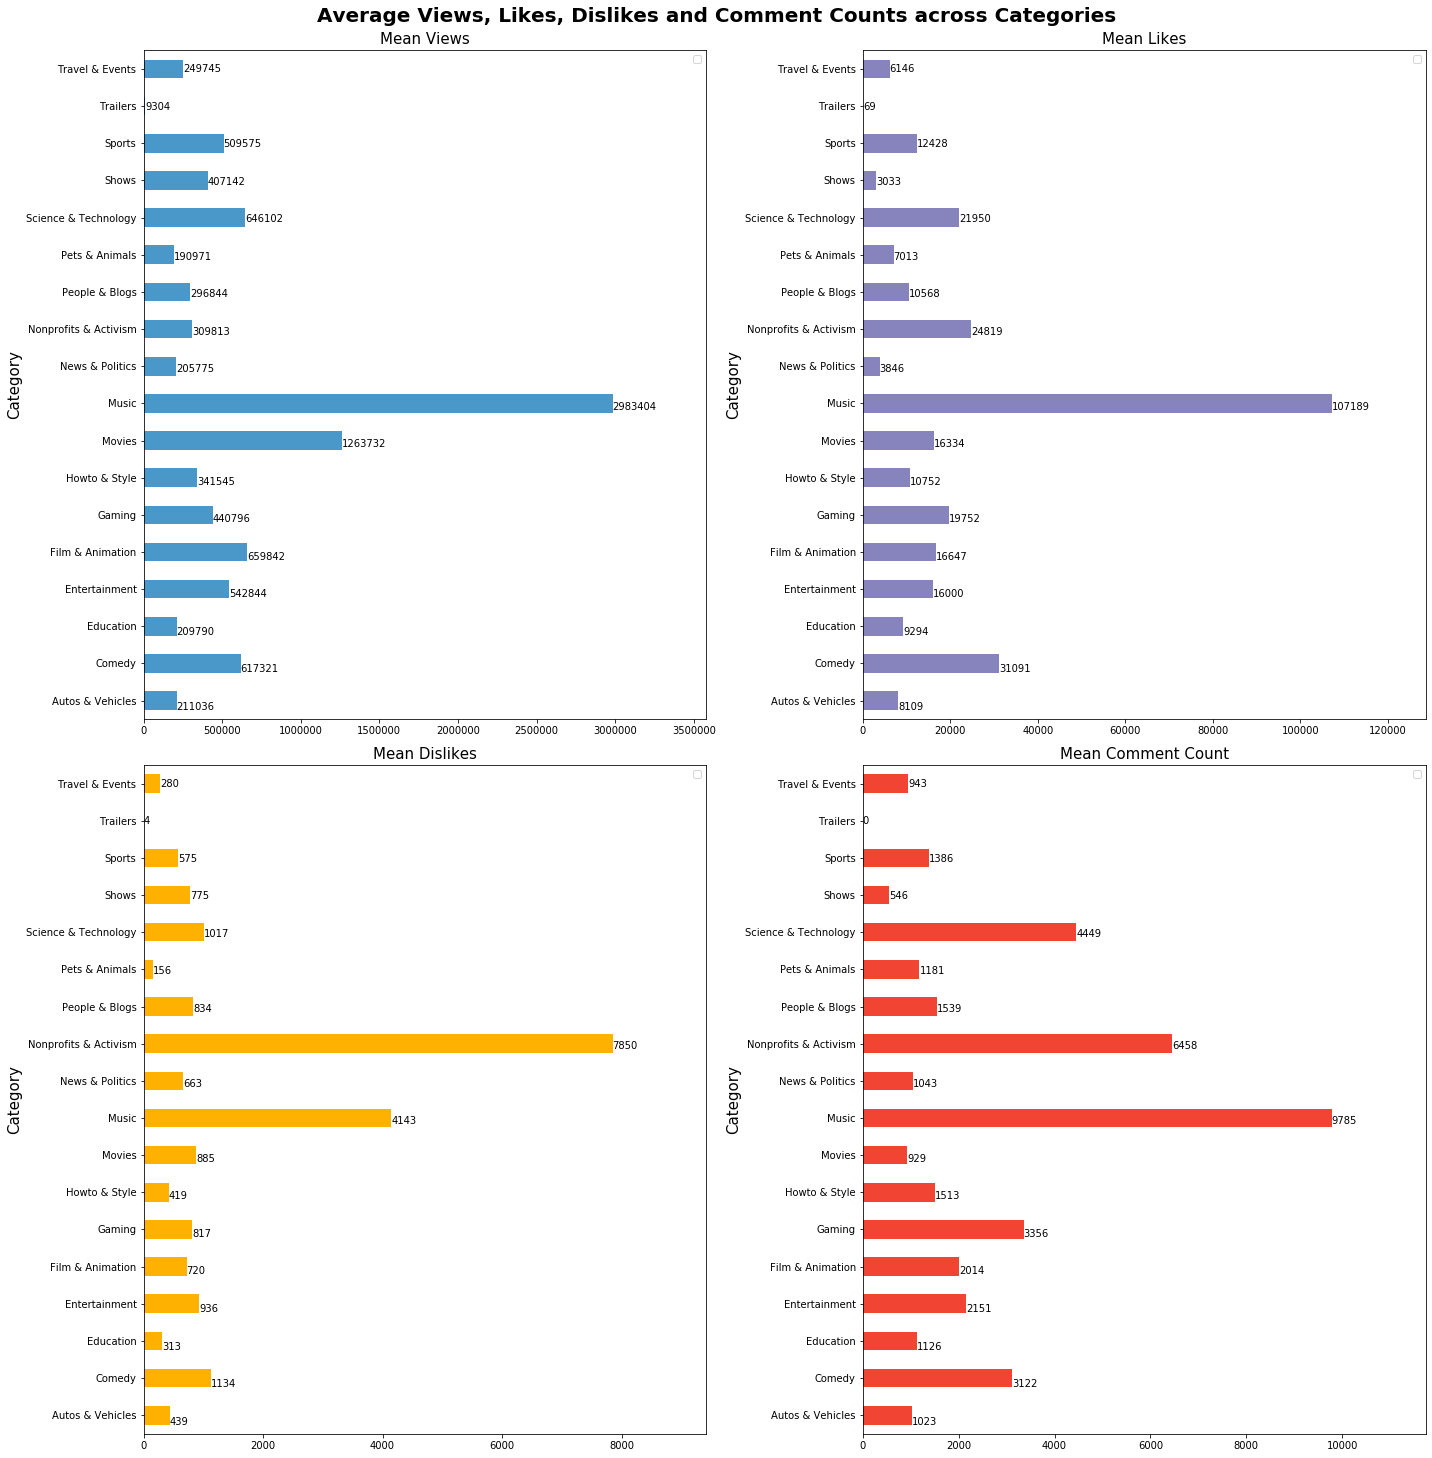

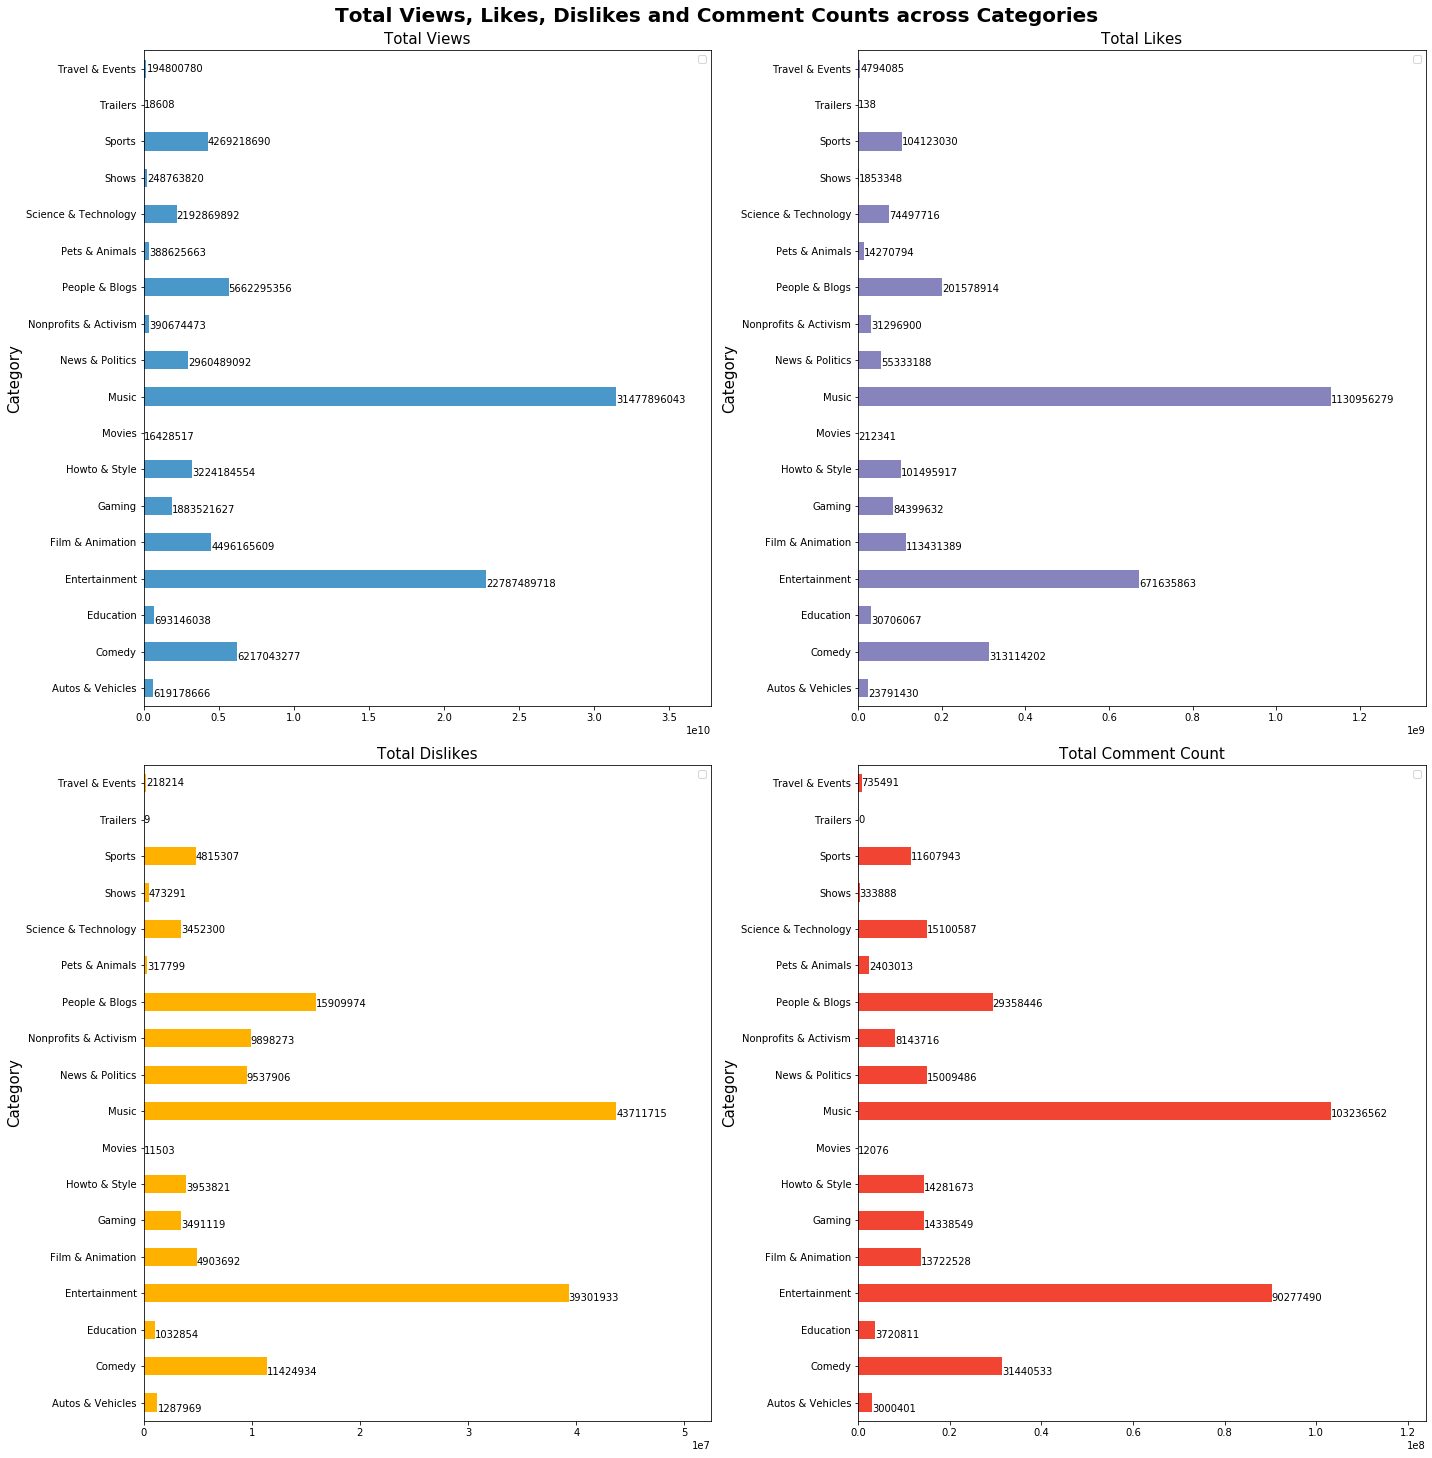

In [170]:

DF_FS_Category = DF_FS.groupby('Category').aggregate(Mean_Views = ('Views_F', 'mean'), Mean_Likes = ('Likes_F', 'mean'), Mean_Dislikes = ('Dislikes_F', 'mean'), Mean_Comment_Count = ('Comment_Count_F', 'mean'))   

plot_barh(DF_FS_Category, Title="Views, Likes, Dislikes and Comment Counts across", Type='Average', across="Categories", figsize=(20,20), adjust=1.01)

DF_FS_Category = DF_FS.groupby('Category').aggregate(Total_Views = ('Views_F', 'sum'), Total_Likes = ('Likes_F', 'sum'), Total_Dislikes = ('Dislikes_F', 'sum'), Total_Comment_Count = ('Comment_Count_F', 'sum'))
plot_barh(DF_FS_Category, Title="Views, Likes, Dislikes and Comment Counts across", Type="Total", across="Categories", figsize=(20,20), adjust=1.01)




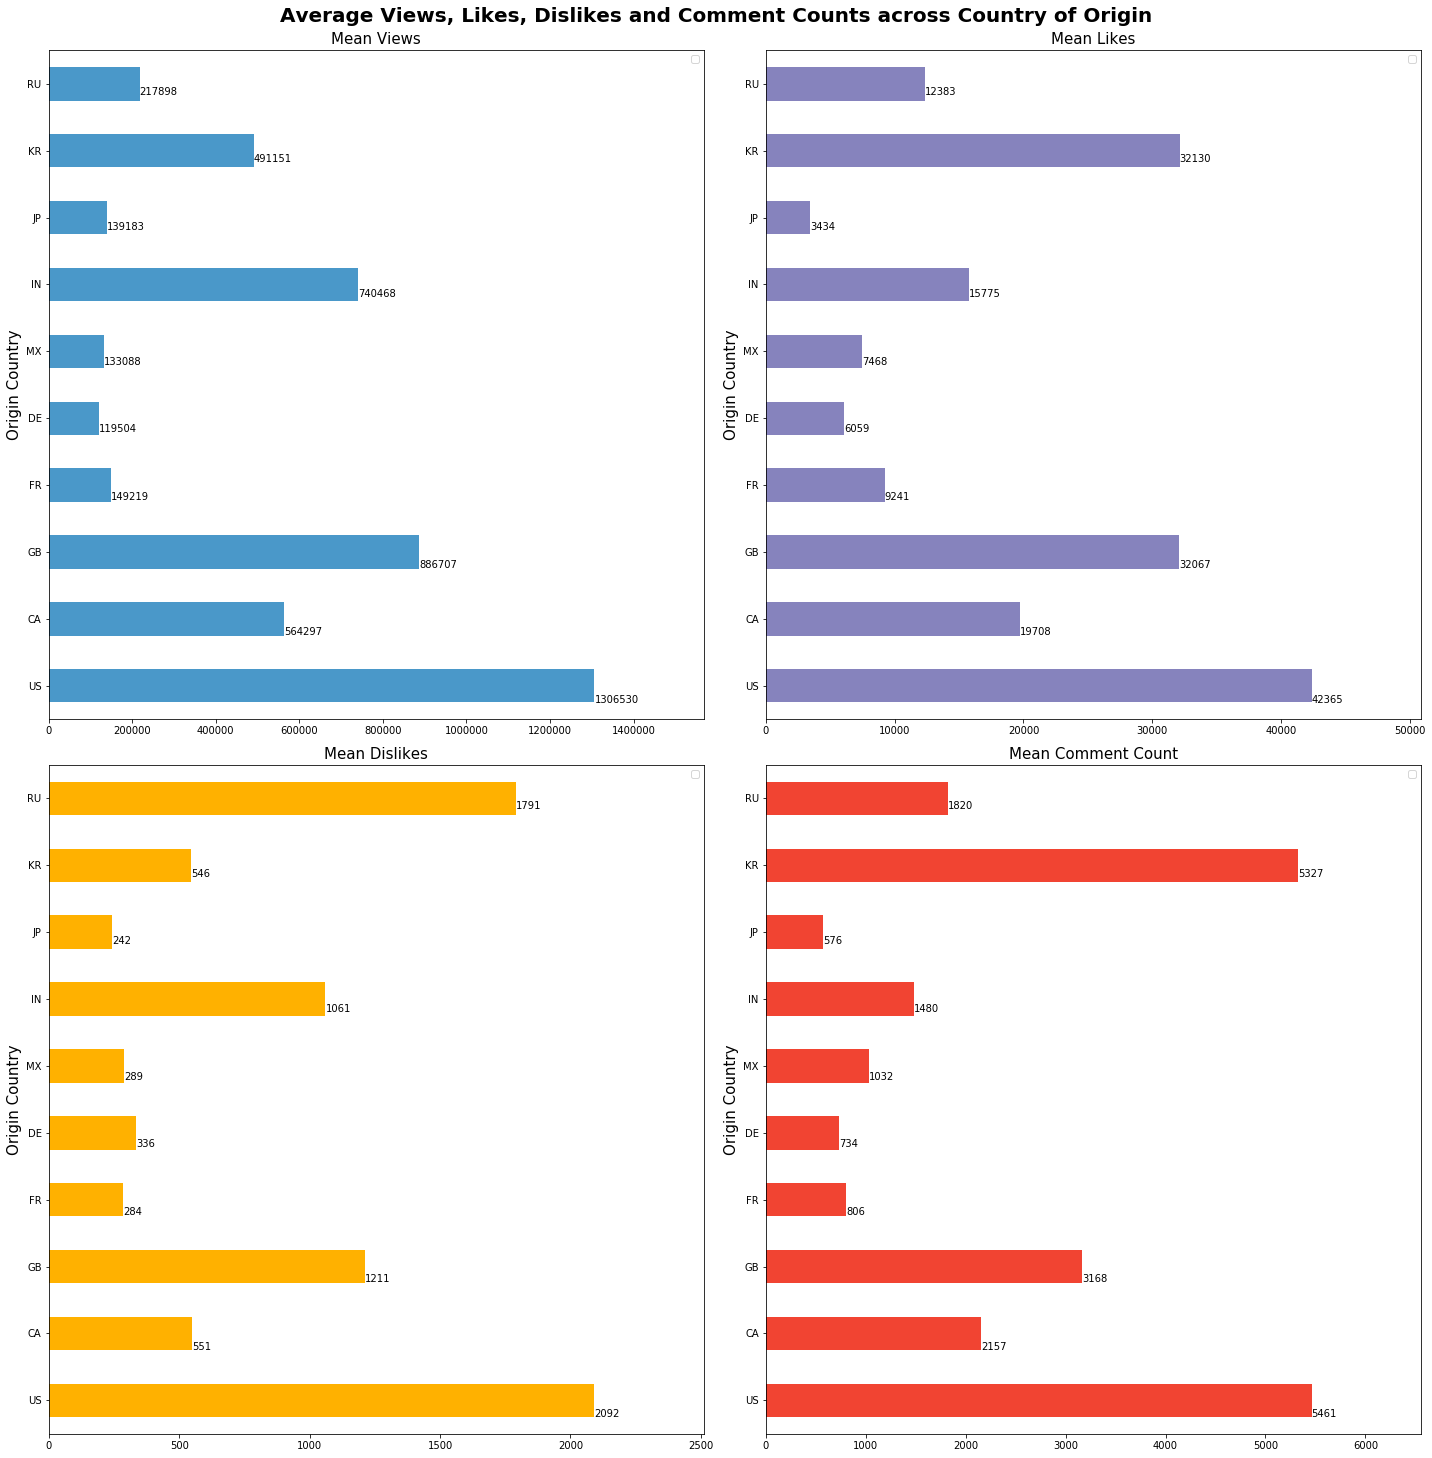

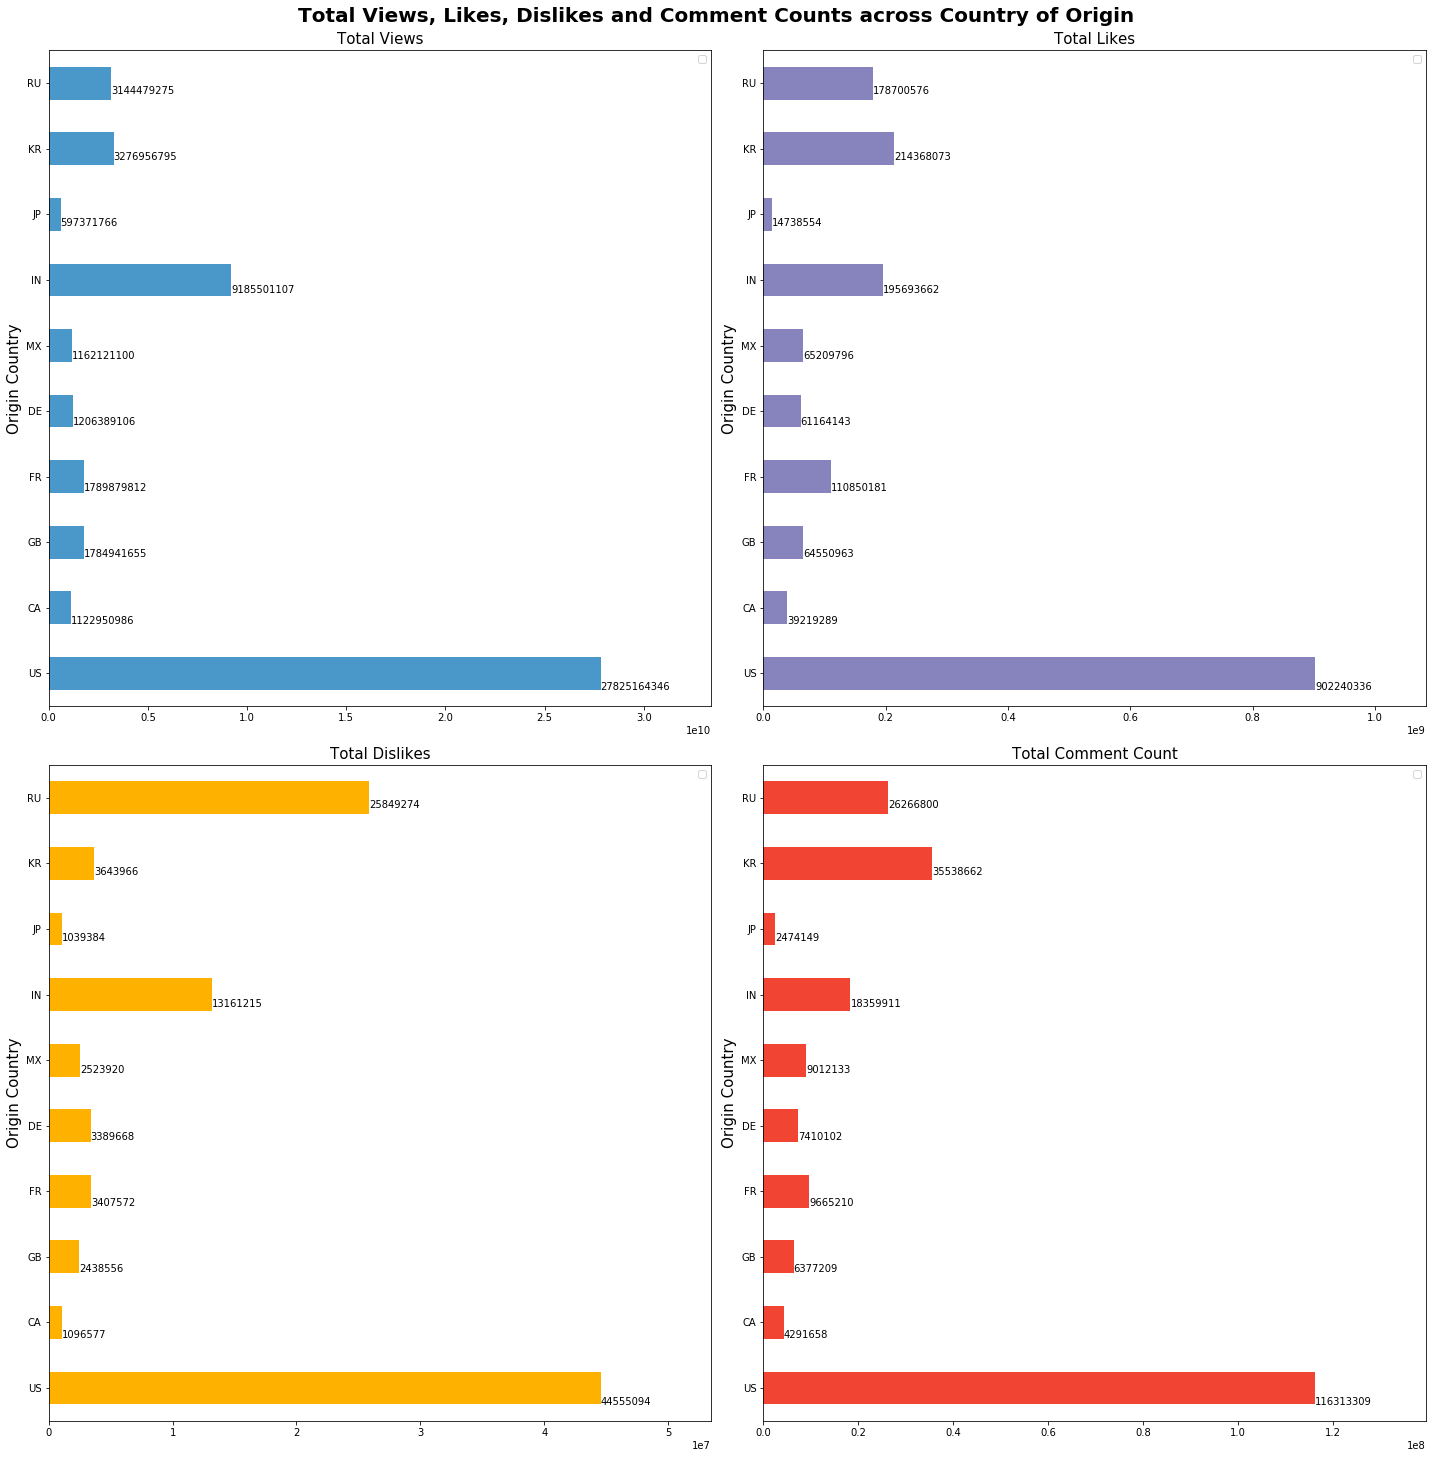

In [171]:
DF_FS_Origin = DF_FS.groupby('Origin_Country').aggregate(Mean_Views = ('Views_F', 'mean'), Mean_Likes = ('Likes_F', 'mean'), Mean_Dislikes = ('Dislikes_F', 'mean'), Mean_Comment_Count = ('Comment_Count_F', 'mean'))

plot_barh(DF_FS_Origin.loc[['US','CA', 'GB', 'FR', 'DE', 'MX', 'IN', 'JP', 'KR', 'RU'], :], Title="Views, Likes, Dislikes and Comment Counts across", Type='Average', across="Country of Origin", figsize=(20,20), adjust=1.01)

DF_FS_Origin = DF_FS.groupby('Origin_Country').aggregate(Total_Views = ('Views_F', 'sum'), Total_Likes = ('Likes_F', 'sum'), Total_Dislikes = ('Dislikes_F', 'sum'), Total_Comment_Count = ('Comment_Count_F', 'sum'))

plot_barh(DF_FS_Origin.loc[['US','CA', 'GB', 'FR', 'DE', 'MX', 'IN', 'JP', 'KR', 'RU'], :], Title="Views, Likes, Dislikes and Comment Counts across", Type='Total', across="Country of Origin", figsize=(20,20), adjust=1.01)


# Manual One way ANOVA Test on Quantitative Variables for Popularity Bucket
**The F-value scores examine if, when we group the quantitative variables by the popularity bucket, the means for each group are significantly different.**

- **Assumptions:** 
  We don't have normality, however, if that is accepted if the sample size in each group is above 20 (It holds true in our case)
- **This result also shows that all the mean values (of all of the quantitative variables) across the popularity buckets are not the same**


In [172]:
DF = pd.read_pickle("../Data/Popularity_DF.pkl")
DF=cleanup(DF)
pop_buckets = ['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon']
sts.f_oneway(*[DF[DF['Popularity_Category']==bucket][['Trended_After(Days)','Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'PublishedAfter_in_Days']] for bucket in pop_buckets])

F_onewayResult(statistic=array([ 126.25689231,  503.74984728, 1851.59958288, 1376.40544717,
        481.38935889,  710.69884855, 1021.07865493]), pvalue=array([1.13317581e-081, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       3.14170798e-311, 0.00000000e+000, 0.00000000e+000]))

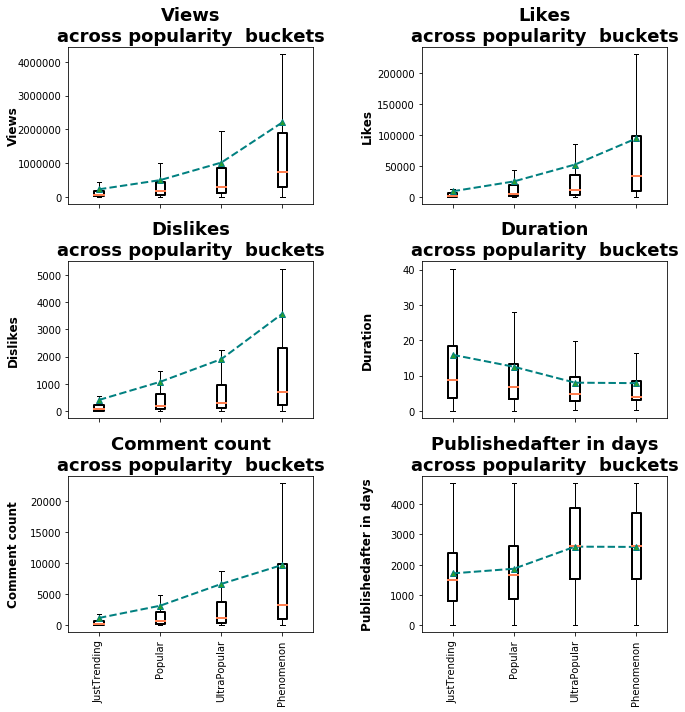

In [173]:
def box_plot_func(col, ax):
    # Create a boxplot to compare means
    #Box plot to convey the same effectively!
    boxprops = dict(linestyle='-', linewidth=2, color='k')
    medianprops = dict(linestyle='-', linewidth=2, color='coral')
    meanprops = dict(markeredgecolor='teal')


    pop_buckets = ['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon']
    for position, bucket in enumerate(pop_buckets):
        _=ax.boxplot(DF[DF['Popularity_Category']==bucket][col], 
                   positions=[position],
                   showfliers=False,
                   showmeans=True,
                   boxprops=boxprops,
                   medianprops=medianprops,
                   meanprops=meanprops)
    _=ax.set_title(f"{col.replace('_',' ').capitalize()}\nacross popularity  buckets", fontsize=18,  weight='bold', y=1)
    _=ax.text(-0.25, 0.5, f"{col.replace('_',' ').capitalize()}", va='center', rotation='vertical', fontsize = 12, weight='bold', transform = ax.transAxes)
    _=ax.set_xticks(range(position+1))
    _=ax.set_xticklabels(pop_buckets, rotation=90)
    _=ax.set_xlim(xmin=-0.5)
    _=ax.plot(DF.groupby('Popularity_Category')[col].mean().loc[['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon']], c='teal', linewidth=2, linestyle='--')

fig, axs = plt.subplots(3, 2, sharex=True, sharey=False, tight_layout=True, figsize=(10,10))
axs = axs.ravel()
Title = [None]*5 + ['Days taken to publish the video since the channel creation']
for index, col in enumerate(['Views', 'Likes', 'Dislikes', 'Duration', 'Comment_Count', 'PublishedAfter_in_Days']):
    box_plot_func(col, axs[index])
    
_=fig.tight_layout(pad=8) 
#_=plt.savefig(f"../Image/Numeric_variables_Across_popularity_buckets.png",bbox_inches = "tight")
plt.show()
    
    